In [1]:
# Installing necessary Packages

!pip install opencv-python

In [2]:
!pip install tensorflow

In [4]:
# Importing necessary libraries

import os

import cv2

import numpy as np

from tqdm import tqdm

# Data Preprocessing

In [ ]:
import zipfile
import os

# Define the path to the zip file
zip_file_path = "archive.zip"  # Update this with the actual zip file name
extract_path = "Biometrics/CASIA_B_extracted"  # Folder where extracted files will be stored

# Create the extraction folder if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed successfully!")


In [5]:
dataset_path = "Biometrics/CASIA_B_extracted/output"

In [6]:
import os

import random

import shutil

from pathlib import Path

# Setting the seed for reproducibility

random.seed(42)

def split_dataset(dataset_path, output_path, train_ratio=0.7, val_ratio=0.15):
    
    # Create train, validation, and test directories
    
    train_dir = os.path.join(output_path, 'train')
    
    val_dir = os.path.join(output_path, 'validation')
    
    test_dir = os.path.join(output_path, 'test')

    os.makedirs(train_dir, exist_ok=True)
    
    os.makedirs(val_dir, exist_ok=True)
    
    os.makedirs(test_dir, exist_ok=True)

    # Iterating through all the subject folders
    
    for subject_id in range(1, 125):
        
        subject_folder = os.path.join(dataset_path, f'{subject_id:03d}')
        
        subject_images = []

        # Gathering all images for the current subject
        
        for root, _, files in os.walk(subject_folder):
            
            for file in files:
                
                if file.endswith('.png') or file.endswith('.jpg'):
                    
                    subject_images.append(os.path.join(root, file))

        # Shuffling the images
        
        random.shuffle(subject_images)

        # Calculating the number of images for each partition
        
        total_images = len(subject_images)
        
        train_count = int(total_images * train_ratio)
        
        val_count = int(total_images * val_ratio)
        
        test_count = total_images - train_count - val_count

        # Spliting the images into train, validation, and test sets
        
        train_images = subject_images[:train_count]
        
        val_images = subject_images[train_count:train_count + val_count]
        
        test_images = subject_images[train_count + val_count:]

        # Copying the images to their respective directories
        
        for partition, images in zip(['train', 'validation', 'test'], [train_images, val_images, test_images]):
            
            partition_dir = os.path.join(output_path, partition, f'{subject_id:03d}')
            
            os.makedirs(partition_dir, exist_ok=True)

            for image_path in images:
                
                shutil.copy(image_path, os.path.join(partition_dir, Path(image_path).name))

# Setting the path to the original dataset and the output directory

dataset_path = "Biometrics/CASIA_B_extracted/output"

output_path = "Biometrics/CASIA_B_Split"

# Spliting the dataset

split_dataset(dataset_path, output_path)


In [7]:
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setting the path to the output directory

output_path = "Biometrics/CASIA_B_Split"

# Defining the output image size

output_image_size = (224, 224)

def grayscale_to_rgb_preprocessing(x):
    
    x = np.stack([x[..., 0], x[..., 0], x[..., 0]], axis=-1)
    
    return x


data_gen = ImageDataGenerator(preprocessing_function=grayscale_to_rgb_preprocessing,
                              
                              rescale=1./255,
                              
                              rotation_range=15,
                              
                              width_shift_range=0.1,
                              
                              height_shift_range=0.1,
                              
                              horizontal_flip=True)

# Defining the ImageDataGenerator for validation and test sets (no augmentation)

validation_data_gen = ImageDataGenerator(preprocessing_function=grayscale_to_rgb_preprocessing, rescale=1./255)

# Creating iterators for the train, validation, and test sets

train_iterator = data_gen.flow_from_directory(os.path.join(output_path, 'train'),
                                              
                                              target_size=output_image_size,
                                              
                                              color_mode='rgb',
                                              
                                              batch_size=32,
                                              
                                              class_mode='categorical')

validation_iterator = validation_data_gen.flow_from_directory(os.path.join(output_path, 'validation'),
                                                              
                                                              target_size=output_image_size,
                                                              
                                                              color_mode='rgb',
                                                              
                                                              batch_size=32,
                                                              
                                                              class_mode='categorical')

test_iterator = validation_data_gen.flow_from_directory(os.path.join(output_path, 'test'),
                                                        
                                                        target_size=output_image_size,
                                                        
                                                        color_mode='rgb',
                                                        
                                                        batch_size=32,
                                                        
                                                        class_mode='categorical')


Found 782803 images belonging to 124 classes.
Found 167694 images belonging to 124 classes.
Found 167876 images belonging to 124 classes.


In [8]:
train_dataset_size = train_iterator.n

validation_dataset_size = validation_iterator.n

test_dataset_size = test_iterator.n

batch_size = 32

#Reduced batch size to speed up the training process.

train_steps_per_epoch = int(np.ceil(train_dataset_size / batch_size))

validation_steps_per_epoch = int(np.ceil(validation_dataset_size / batch_size))

test_steps_per_epoch = int(np.ceil(test_dataset_size / batch_size))

In [9]:
def create_pairs_and_labels(data_iterator, steps_per_epoch):
    
    for _ in range(steps_per_epoch):
        
        try:
            
            # Getting the next batch of images and labels
            
            images, labels = next(data_iterator)
            
        except StopIteration:
            
            # If the iterator reaches the end of the dataset, reset the iterator and continue
            
            data_iterator.reset()
            
            images, labels = next(data_iterator)

        # Calculating the number of pairs
        
        num_pairs = images.shape[0] * 2

        # Creating an empty array for the image pairs and labels
        
        image_pairs = np.zeros((num_pairs, 2, images.shape[1], images.shape[2], images.shape[3]))
        
        pair_labels = np.zeros((num_pairs,))

        for i in range(0, num_pairs, 2):
            
            idx1 = i // 2

            # Positive pair
            
            image_pairs[i, 0] = images[idx1]
            
            image_pairs[i, 1] = images[idx1]
            
            pair_labels[i] = 1

            # Negative pair
            
            idx2_candidates = np.where(labels != labels[idx1])[0]
            
            idx2 = np.random.choice(idx2_candidates)
            
            image_pairs[i + 1, 0] = images[idx1]
            
            image_pairs[i + 1, 1] = images[idx2]
            
            pair_labels[i + 1] = 0

        yield [image_pairs[:, 0], image_pairs[:, 1]], pair_labels


In [10]:
# Create iterators for the train, validation, and test sets that generate image pairs and their labels

train_pair_iterator = create_pairs_and_labels(train_iterator, train_steps_per_epoch)

validation_pair_iterator = create_pairs_and_labels(validation_iterator, validation_steps_per_epoch)

test_pair_iterator = create_pairs_and_labels(test_iterator, test_steps_per_epoch)

In [11]:
from tensorflow.keras.applications import MobileNetV2

# Loading the pre-trained MobileNetV2 model without the top classification layer

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Using MobileNetV2 model with pre-trained weights. 

#This is a good strategy to speed up the training, as the model has already learned useful features from a large dataset.


In [12]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Flatten, Dense, Lambda, Subtract

from tensorflow.keras.models import Model

def create_siamese_model(base_model):
    
    # Defining the input tensors for the two input images
    
    input_left = Input(shape=(224, 224, 3))
    
    input_right = Input(shape=(224, 224, 3))

    # Processing both input images using the same base model
    
    processed_left = base_model(input_left)
    
    processed_right = base_model(input_right)
    
    print("Processed left shape:", processed_left.shape) 
    
    print("Processed right shape:", processed_right.shape) 

    # Flattening the feature vectors
    
    flat_left = Flatten()(processed_left)
    
    flat_right = Flatten()(processed_right)

    # Computing the L1 distance between the two feature vectors
    
    distance = Lambda(lambda x: tf.abs(x[0] - x[1]))([flat_left, flat_right])

    # Adding a dense layer to learn the embeddings
    
    embeddings = Dense(128, activation='relu')(distance)

    # Adding the final output layer
    
    output = Dense(1, activation='sigmoid')(embeddings)

    # Creating the Siamese model
    
    siamese_model = Model(inputs=[input_left, input_right], outputs=output)

    return siamese_model

# Create the Siamese network with the pre-trained MobileNetV2 model
siamese_model = create_siamese_model(base_model)


Processed left shape: (None, 7, 7, 1280)
Processed right shape: (None, 7, 7, 1280)


In [13]:
# Determining the number of training and validation steps per epoch

train_steps_per_epoch = len(train_iterator)

validation_steps = len(validation_iterator)

siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the Siamese network using the pair iterators

history = siamese_model.fit(train_pair_iterator,
                            
                            validation_data=validation_pair_iterator,
                            
                            steps_per_epoch=train_steps_per_epoch,
                            
                            validation_steps=validation_steps,
                            
                            batch_size=32,
                            
                            epochs=1)


24463/24463 [==============================] - 269246s 11s/step - loss: 0.0116 - accuracy: 0.9980 - val_loss: 3.2063e-04 - val_accuracy: 0.9999


In [14]:
test_loss, test_accuracy = siamese_model.evaluate(test_pair_iterator, steps=test_steps_per_epoch)

print("Test loss:", test_loss)

print("Test accuracy:", test_accuracy)


5247/5247 [==============================] - 10152s 2s/step - loss: 4.3947e-04 - accuracy: 0.9999
Test loss: 0.0004394710995256901
Test accuracy: 0.9998868107795715


In [29]:

siamese_model.save('siamese_model.h5')


In [37]:
test_pair_iterator = create_pairs_and_labels(test_iterator, test_steps_per_epoch)

y_pred = siamese_model.predict(test_pair_iterator, steps=test_steps_per_epoch)

y_pred_labels = np.where(y_pred > 0.5, 1, 0)  # Converting probabilities to binary labels


5247/5247 [==============================] - 9854s 2s/step


In [38]:
test_pair_iterator = create_pairs_and_labels(test_iterator, test_steps_per_epoch)

y_true_labels = []

for i in range(test_steps_per_epoch):
    
    _, labels_batch = next(test_pair_iterator)
    
    y_true_labels.extend(labels_batch)
    
y_true_labels = np.array(y_true_labels)


In [39]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true_labels, y_pred_labels, average='binary')

auc_roc = roc_auc_score(y_true_labels, y_pred)

print(f"Precision: {precision}")

print(f"Recall: {recall}")

print(f"F1-score: {f1_score}")

print(f"AUC-ROC: {auc_roc}")


Precision: 0.9997558317502099
Recall: 1.0
F1-score: 0.9998779009687515
AUC-ROC: 1.0


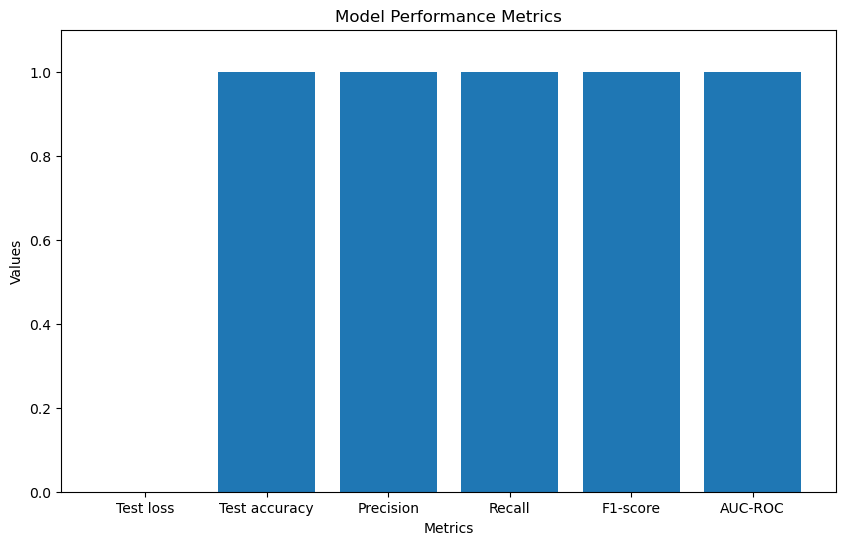

                 Values
Test loss      0.000439
Test accuracy  0.999887
Precision      0.999756
Recall         1.000000
F1-score       0.999878
AUC-ROC        1.000000


In [40]:
import matplotlib.pyplot as plt

import pandas as pd

# Metrics to plot

metrics = ['Test loss', 'Test accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']

values = [test_loss, test_accuracy, precision, recall, f1_score, auc_roc]

# Create a bar plot

plt.figure(figsize=(10, 6))

plt.bar(metrics, values)

plt.xlabel('Metrics')

plt.ylabel('Values')

plt.title('Model Performance Metrics')

plt.ylim([0, 1.1])

plt.show()

# Creating a table using pandas

results_df = pd.DataFrame(values, index=metrics, columns=['Values'])

print(results_df)
